In [76]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")

In [2]:
# 1. Backtest.py 

import datetime
import pprint #good lib for data output
try:
    import Queue as queue
except ImportError:
    import queue
import time

class Backtest():
    def __init__(
        self, csv_dir, symbol_list, initial_capital, heartbeat,
        start_date, data_handler, execution_handler, portfolio, strategy):
        """
        Initialize the backtest
        Parameters:
        csv_dir - The hard root to the CSV data directory
        symbol_list - The list of symbol strings
        initial_capital - The starting capital for the portfolio
        heartbeat - Backtest "heartbeat in seconds"
        start_date - The start datetime of the strategy
        data_handler - (Class) Handles the market feed
        execution_handler - (Class) Handles the orders/fills for trades
        portfolio - (Class) Keeps track of portfolio current and prior position
        strategy - (Class) Generates signals based on market data
        """
        self.csv_dir = csv_dir
        self.symbol_list = symbol_list
        self.initial_capital = initial_capital
        self.heartbeat = heartbeat 
        self.start_date = start_date

        self.data_handler_cls = data_handler
        self.execution_handler_cls = execution_handler
        self.portfolio_cls = portfolio
        self.strategy_cls = strategy
        
        self.signals = 0
        self.orders = 0
        self.fills = 0
        
        self.events = queue.Queue()
        
        self._generate_trading_instances()
        
    def _generate_trading_instances(self):
        """
        Generates the trading instance objects from their class types
        """
        self.data_handler = self.data_handler_cls(self.events, self.csv_dir, self.symbol_list)
        self.strategy = self.strategy_cls(self.data_handler, self.events)
        self.portfolio = self.portfolio_cls(self.data_handler, self.events, self.start_date, self.initial_capital)
        self.execution_handler = self.execution_handler_cls(self.events)
    
    def _run_backtest(self):
        """
        Executes the backtest
        """
        i = 0
        while True:
            i += 1
            
            # Update market bars
            if self.data_handler.continue_backtest == True:
                self.data_handler.update_bars()
            else:
                break
            
            # Handle the events
            while True:
                try:
                    event = self.events.get(False)
                except queue.Empty:
                    break
                if event is not None:
                    if event.type == 'MARKET':
                        self.strategy.calculate_signals(event)
                        self.portfolio.update_timeindex(event)
                        
                    elif event.type == 'SIGNAL':
                        self.signals += 1
                        self.portfolio.update_signal(event)
                    
                    elif event.type == 'ORDER':
                        self.orders += 1
                        self.execution_handler.execute_order(event)
                    
                    elif event.type == 'FILL':
                        self.fills += 1
                        self.portfolio.update_fill(event)
            
            time.sleep(self.heartbeat)
    
    def _output_performance(self):
        """
        Output the strategy performance from the backtest.
        """
        self.portfolio.create_equity_curve_dataframe()
#         print("*****backtest.py: 4. Backtest._output_performance*****")
        print("Creating summary stats...")
        stats = self.portfolio.output_summary_stats()
        
        print("Creating equity curve...")
        print(self.portfolio.equity_curve.tail(10))
        pprint.pprint(stats) #??

        print("Signals: %s" % self.signals)
        print("Orders: %s" % self.orders)
        print("Fills: %s" % self.fills)
        
    def simulate_trading(self):
        """
        Simulate the backtest
        """
        self._run_backtest()
        self._output_performance()

In [3]:
# 2.Event.py

class Event():
    """
    Base class providing an interface for all inherited events, which
    will trigger further events in the trading infrastructure
    """
    
    pass

class MarketEvent(Event):
    """
    Handles the evnet of receiving a new market update with corresponding bars
    """
    def __init__(self):
        self.type = 'MARKET'

class SignalEvent(Event):
    """
    Handles the event of sending a Signal from a Strategy object
    Then received by a Portfolio object and act upon
    """
    def __init__(self, strategy_id, symbol, datetime, signal_type):
        """
        Initialize the Signal Event
        Parameters:
        strategy_id - The unique ID of the strategy sending the signal
        symbol - The ticker symbol, e.g 'AAPL'
        datetime - The timestamp at which the signal was generated
        signal_type - 'LONG' or 'SHORT'
        
        """
        self.strategy_id = strategy_id
        self.type = 'SIGNAL'
        self.symbol = symbol
        self.datetime = datetime
        self.signal_type = signal_type
        
class OrderEvent(Event):
    """
    Handles the event of sending an Order to an execution system
    The order contains a symbol, a type(market or limit), quantity and direction
    """
    def __init__(self, symbol, order_type, quantity, direction):
        """
        Initialize the order type, setting whether it is a Market order('MKT')
        or Limit order('LMT'). Has a quantity and direction ('BUY' or 'SELL')
        TODO: Should handle error checking on rational orders 
        (i.e. no negative quantities etc)
        Parameters:
        symbol - The instrument to trade
        order_type - 'MKT' or 'LMT' for Market or Limit
        quantity - Non-negative integer for quantity
        direction - 'BUY' or 'SELL' for long or short
        """
        self.type = 'ORDER'
        self.symbol = symbol
        self.order_type = order_type
        self.quantity = quantity
        self.direction = direction
        
    def print_order(self):
        """
        Output the values within the Order
        """
        print(
            "Order: Symbol=%s, Type=%s, Quantity=%s, Direction=%s" %
            (self.symbol, self.order_type, self.quantity, self.direction)
        )


class FillEvent(Event):
    """
    Encapsulate the notion of a Filled Order, returned from a brokerage.
    Stores the quanitity of an instrument actually filled and at what price.
    In addition, stores the commission of the trade from the brokerage.
    TODO: SHOULD support filling positions at different prices
    """
    def __init__(self, timeindex, symbol, exchange, quantity, 
                 direction, fill_cost, commission=None): #jj commission
        """
        Initialize the FillEvent object. Sets the symbol, exchange, quantity,
        direction, cost of fill and optional commission
        If commission is not provided, the Fill object will calculate it based 
        on the trade size and the Interactive Brokers fees
        Parameters:
        timeindex - The bar when the order was filled
        symbol - The instrument which was filled
        exchange - The exchange where the order was filled
        quantity - The filled quantity
        direction - The direction of fill ('BUY' or 'SELL')
        fill_cost - The holdings value in dollars
        commission - Optional commission sent from IB
        """
        self.type = 'FILL'
        self.timeindex = timeindex
        self.symbol = symbol
        self.exchange = exchange
        self.quantity = quantity
        self.direction = direction
        self.fill_cost = fill_cost
        
       
        if commission is None:
            self.commission = self.calculate_ib_commission()
        else:
            self.commission = comission
        
    def calculate_ib_commission(self):
        if self.quantity <= 300000:
            commission = max(0.0035*self.quantity, 0.35)
        else:
            commission = max(0.0035*(300000) + (self.quantity-300000)*0.002 ,0.7)
        
        return commission
#         full_cost = commissions 
#         return full_cost

In [4]:
#3. Data.py

from abc import ABCMeta, abstractmethod
import datetime
import os, os.path

class DataHandler(metaclass=ABCMeta): 
    #ABCMeta to control all abstractmethods must be overwritten, or
    #the object of inhereted class won't be initiated (TypeError will occur)
    """ 
    DataHandler is an abstract base class providing an interface for all inherited
    data handlers.
    The goal of a (derived) DataHandler object is to output a generated set of bars 
    (OHLCVI) for each symbol requested.
    This will simulate how a live strategy would function as current market data.
    Historic and live system will be treated identically
    """
    
    @abstractmethod
    def get_latest_bar(self, symbol):
        """
        Return the last updated bar
        """
        pass

    @abstractmethod
    def get_latest_bars(self, symbol, N=1):
        """
        Return the last N updated bars
        """
        pass
    
    @abstractmethod
    def get_latest_bar_datetime(self, symbol):
        """
        Return a datetime object for the last bar
        """
        pass
    
    @abstractmethod
    def get_latest_bar_value(self, symbol, val_type):
        """ 
        Return one of the Open, High, Low, Close, Volume or 
        OI (Open Interest, reserved for futures) from the last bar
        """
        pass
    
    @abstractmethod
    def get_latest_bars_values(self, symbol, val_type, N=1):
        """
        Return the last N bar values from the latest symbol list,
        or N-k if less available
        """
        pass
    
    @abstractmethod
    def update_bars(self):
        """
        Push the latest bars to the bars_queue for each symbol in
        a tuple OHLCVI format: 
        (datetime, open, high, low, close, volume, open interest)
        """
        pass


    
class HistoricCSVDataHandler(DataHandler):
    """
    Read CSV files for each requested symbol from disk and provide an 
    interface to obtain the latest bar in a manner identical to a live
    trading interface
    """
    print("--------------HistoricCSVDataHandler-------------")
    def __init__(self, events, csv_dir, symbol_list):
        """ 
        Initialize the historic data handler by requesting the location 
        of the CSV files and a list of symbols.
        Assumed that all files are of the form 'symbol.csv', where symbol
        is a string in the list
        Parameters:
        events - The Event Queue
        csv_dir - Absolute directory path to the CSV files
        symbol_list - A list of symbol strings
        """
        self.events = events
        self.csv_dir = csv_dir
        self.symbol_list = symbol_list
        
        self.symbol_data = {}
        self.latest_symbol_data = {}
        self.continue_backtest = True
        self.bar_index = 0
        self.backtest_start_date = backtest_start_date
        
        self._open_convert_csv_files()
    
    def _open_convert_csv_files(self):
        """
        Opens the CSV files from data directory, converting them into
        pandas DataFrames within a symbol dictionary
        Assume data is taken from Yahoo
        """
        comb_index = None # index union for all tickers
        
        for s in self.symbol_list:
            # Load the CSV file with no header information, index on date
            self.symbol_data[s] = pd.io.parsers.read_csv(
                os.path.join(self.csv_dir, '%s.csv'%s), 
                header=0, index_col=0, parse_dates=True,
                names=data_cols #global var (list) in main.py
            )
            
            # In case the first column is not date
            self.symbol_data[s].reset_index(inplace=True)
            self.symbol_data[s].set_index(date_col, inplace=True) 
            # reset the backtest start date
            self.symbol_data[s] = self.symbol_data[s][backtest_start_date:]
            
            if comb_index is None:
                comb_index = self.symbol_data[s].index
            else:
                comb_index.union(self.symbol_data[s].index)
            
            # Set the latest symbol data to None, used in update_bar()
            self.latest_symbol_data[s] = []
        
        # Reindex the dataframes & replace missing values by previous valid one
        for s in self.symbol_list:
            self.symbol_data[s] = self.symbol_data[s].\
                        reindex(comb_index, method='pad').iterrows()
    
    def get_latest_bar(self, symbol):
        """
        Return the last bar from the latest symbol data dict
        """
        try:
            bars_list = self.latest_symbol_data[symbol]
        except KeyError:
            print("Symbol is not available in the historical data set")
        else:
            return bars_list[-1:]
    
    def get_latest_bars(self, symbol, N=1):
        """
        Return the last N bars from the latest symbol data dic
        """
        try:
            bars_list = self.latest_symbol_data[symbol]
        except KeyError:
            print("Symbol is not available in the historical data set")
        else:
            return bars_list[-N:]
    
    def get_latest_bar_datetime(self, symbol):
        """
        Return a datetime object for the last bar
        """
        try:
            bars_list = self.latest_symbol_data[symbol]
        except KeyError:
            print("Symbol is not available in the historical data set")
        else:
            return bars_list[-1][0]
        
    def get_latest_bar_value(self, symbol, val_type):
        """
        Return one of the Open, High, Low, Close, Volume or OI
        values from the pandas Bar series object.
        """
        try:
            bars_list = self.latest_symbol_data[symbol]
        except KeyError:
            print("Symbol is not available in the historical data set")
        else:
            return bars_list[-1][1][val_type] 
    
    def get_latest_bars_values(self, symbol, val_type, N=1):
        """
        Return the last N bars of the Open, High, Low, Close, Volume or OI
        values from the pandas Bar series object.
        """
        try:
            bars_list = self.get_latest_bars(symbol, N)
        except KeyError:
            print("Symbol is not available in the historical data set")
        else:
            return np.array([getattr(b[1], val_type) for b in bars_list])
    
    def _get_new_bar(self, symbol):
        """
        Return the latest bar from the data feed
        An Iterator 
        """
        for b in self.symbol_data[symbol]:
            yield b
    
    def update_bars(self):
        """
        Push the latest bar to the latest symbol data dict for all
        symbols in the symbol list
        """
        for s in self.symbol_list:
            try:
                bar = next(self._get_new_bar(s))
            except StopIteration:
                self.continue_backtest = False
            else:
                if bar is not None:
                    self.latest_symbol_data[s].append(bar)
            self.events.put(MarketEvent())
            

--------------HistoricCSVDataHandler-------------


In [5]:
#4. Execution.py

class ExecutionHandler(metaclass=ABCMeta):
    """
    Abstract class handles the interaction between a set of order
    objects generated by a Portfolio and the ultimate set of Fill
    objects that actually occur in the market
    """
    @abstractmethod
    def execute_order(self, event):
        """
        Takes an Order Event and execute it, producing a Fill event
        that gets placed onto the Events queue.
        Parameters:
        event - Contains an Event object with order information
        """
        pass

    
class SimulatedExecutionHandler(ExecutionHandler):
    """
    The simulated execution handler simply converts all order objects into
    the equivalent fill objects without latency, slippage or fill-ratio issues
    """
    def __init__(self, events):
        """
        Initialize the handler, setting event queues
        """
        self.events = events
    
    def execute_order(self, event):
        """
        Simply converts order objects into Fill objects
        """
        if event.type == 'ORDER':
            fill_event = FillEvent(
                datetime.datetime.utcnow(), event.symbol, 'ARCA',
                event.quantity, event.direction, None
            )
            self.events.put(fill_event)

In [6]:
#5. Strategy.py

class Strategy(metaclass=ABCMeta):
    """
    Abstract base class providing an interface for all inherited strategies
    The goal of a (derived) Strategy object is to generate Signal objects
    for particular symbols based on the inputs of Bars (OHLCV) generated by
    a DataHandler object
    """
    @abstractmethod
    def calculate_signals(self):
        """
        Proved the mechanisms to calculate the list of signals
        """
        pass

In [7]:
# 6. Portfolio.py

class Portfolio():
    """
    Handles the positions and market value of all instruments
    The positions DataFrame stores a time-index of the quantity
    of positions held.
    The holdings DataFrame stores the cash and total market holdings
    value of each symbol for a particular time-index, and percentage
    change in portfolio across bars
    """
    def __init__(self, bars, events, start_date, initial_capital):
        """
        Initialize the portfolio with bars and an event queue
        Also include a starting datetime index and initial capital
        Parameters:
        bars - The DataHandler object with current market data
        events - The Event Queue object
        start_date - The start date of the portfolio
        initial_capital - The starting capital in USD
        """
        self.bars = bars
        self.events = events
        self.symbol_list = self.bars.symbol_list
        self.start_date = start_date
        self.initial_capital = initial_capital
        
        self.all_positions = self.construct_all_positions()
        #all symbols' current position set to 0
        self.current_positions = dict((k,v) for k,v in [(s,0) for s in self.symbol_list])
        self.all_holdings = self.construct_all_holdings()
        self.current_holdings = self.construct_current_holdings()
        
        self.len_symbol_list = len(self.symbol_list)
        
        print('Initial Capital:', self.initial_capital, 'Len Symbol:', self.len_symbol_list)
        print("Position Value for each asset:", self.initial_capital/self.len_symbol_list)
        
    def construct_all_positions(self):
        """
        Construct the positons list using the start_date
        To determine when the time index will begin
        """
        d = dict((k,v) for k,v in [(s,0) for s in self.symbol_list] )
        d['datetime'] = self.start_date
        return [d]
    
    def construct_all_holdings(self):
        """
        Construct the holdings list using the start_date
        To determine when the time index will begin
        """
        d = dict((k,v) for k,v in [(s,0.0) for s in self.symbol_list] )
        d['datetime'] = self.start_date
        d['cash'] = self.initial_capital
        d['commission'] = 0.0
        d['total'] = self.initial_capital
        return [d]
    
    def construct_current_holdings(self):
        """
        Construct the dictionay holding the current value of 
        the portfolio across all symbols
        """
        d = dict((k,v) for k,v in [(s,0.0) for s in self.symbol_list] )
        d['cash'] = self.initial_capital
        d['commission'] = 0.0
        d['total'] = self.initial_capital
        return d
    
    def update_timeindex(self, event):
        """
        Add a new record to the positions matrix for the current
        market data bar. 
        Reflect the previous bar, all current market data at this
        stage is known (OHLCV)
        Make use of a MarketEvent from the events queue
        """
        latest_datetime = self.bars.get_latest_bar_datetime(self.symbol_list[0])
        
        # Update positions
        dp = dict((k,v) for k,v in [(s,0.0) for s in self.symbol_list] )
        dp['datetime'] = latest_datetime
        
        for s in self.symbol_list:
            dp[s] = self.current_positions[s]
        
        # Append the current positions
        self.all_positions.append(dp)
        
        # Update holdings
        dh = dict( (k,v) for k, v in [(s, 0) for s in self.symbol_list] )
        dh['datetime'] = latest_datetime
        dh['cash'] = self.current_holdings['cash']
        dh['commission'] = self.current_holdings['commission']
        dh['total'] = self.current_holdings['cash']
        
        for s in self.symbol_list:
            market_value = self.current_positions[s] * \
                            self.bars.get_latest_bar_value(s, "Adj Close")
            dh[s] = market_value
            dh['total'] += market_value
        
        # Append the current holdings
        self.all_holdings.append(dh)
    
    # ================
    # Update from Fill
    # ================
    def update_positions_from_fill(self, fill):
        """
        Takes a Fill object and updates the position matrix to 
        reflect the new positon
        Parameter:
        fill - The Fill object used to update the positions
        """
        fill_dir = 0
        if fill.direction == 'BUY':
            fill_dir = 1
        if fill.direction == 'SELL':
            fill_dir = -1
        
        self.current_positions[fill.symbol] += fill_dir*fill.quantity
    
    def update_holdings_from_fill(self, fill):
        """
        Takes a Fill object and updates the holdings matrix to
        reflect the holdings value
        """
        fill_dir = 0
        if fill.direction == 'BUY':
            fill_dir = 1
        if fill.direction == 'SELL':
            fill_dir = -1
        
        # Update holdings with new quantities
        fill_cost = self.bars.get_latest_bar_value(fill.symbol, price_col)
        cost = fill_dir *fill_cost *fill.quantity
        self.current_holdings[fill.symbol] += cost
        self.current_holdings['commission'] += fill.commission
        self.current_holdings['cash'] -= (cost + fill.commission)
        self.current_holdings['total'] -= (cost + fill.commission) #jj: cost?
    
        return fill_cost
    
    def update_fill(self, event):
        """
        Update portfolio current positions and holdings from a FillEvent
        by calling previous two methods
        """
        if event.type == 'FILL':
            self.update_positions_from_fill(event)
            self.update_holdings_from_fill(event)
    
    def generate_naive_order(self, signal):
        """
        Simply files an Order object as a constant quantity sizing
        of the signal object, without risk managemtn or position sizing
        considerations
        Parameter:
        signal - The tuple containing Signal information (Signal object)
        """
        order = None
        
        symbol = signal.symbol
        direction = signal.signal_type
        
        symbol_value = self.bars.get_latest_bar_value(symbol, price_col)
        mkt_quantity = int(self.initial_capital/self.len_symbol_list/symbol_value)
        print("Generating Signals:", self.bars.get_latest_bar_datetime(ticker) ,end="     ")
        print("Asset:", symbol, "Signal Type:", direction, "%s:"%ticker, round(symbol_value,3), "mkt_quantity:", mkt_quantity)
        cur_quantity = self.current_positions[symbol]
        order_type = 'MKT'
        
        if direction == 'LONG' and cur_quantity == 0:
            order = OrderEvent(symbol, order_type, mkt_quantity, 'BUY')
        if direction == 'SHORT' and cur_quantity == 0:
            order = OrderEvent(symbol, order_type, mkt_quantity, 'SELL')
        
        if direction == 'EXIT' and cur_quantity > 0:
            order = OrderEvent(symbol, order_type, abs(cur_quantity), 'SELL')
        if direction == 'EXIT' and cur_quantity < 0:
            order = OrderEvent(symbol, order_type, abs(cur_quantity), 'BUY')
        return order

    def update_signal(self, event):
        """
        Act on a SignalEvent to generate new orders based on the 
        portfolio logic
        """
        if event.type == 'SIGNAL':
            order_event = self.generate_naive_order(event)
            self.events.put(order_event)
        
    # ========================
    # Post-Backtest Statistics
    # ========================
    
    def create_equity_curve_dataframe(self):
        """
        Create a pandas dataframe from all_holdings list of dict
        """
        curve = pd.DataFrame(self.all_holdings)
        curve.set_index('datetime', inplace=True)
        curve['returns'] = curve['total'].pct_change()
        curve['equity_curve'] = (1+curve['returns']).cumprod()
        self.equity_curve = curve
        
    def output_summary_stats(self):
        """
        Create a list of summary statistics of the portfolio
        """
        total_return = self.equity_curve['equity_curve'][-1]
        returns = self.equity_curve['returns']
        pnl = self.equity_curve['equity_curve']
        
        sharpe_ratio = create_sharpe_ratio(returns, periods=252)
        drawdown, max_dd, dd_duration = create_drawdowns(pnl)
        self.equity_curve['drawdown'] = drawdown
        
        stats = [("Total Return", "%0.2f%%" % ((total_return - 1.0) * 100.0)),
                 ("Sharpe Ratio", "%0.2f" % sharpe_ratio),
                 ("Max Drawdown", "%0.2f%%" % (max_dd * 100.0)),
                 ("Drawdown Duration", "%d" % dd_duration)]
        
        self.equity_curve.to_csv(ticker+"_performance"+".csv")
        
        print(stats)
        

In [8]:
#7. Performance.py

def create_sharpe_ratio(returns, periods=252):
    """
    Create the Sharpe Ratio for the strategy, based on a 
    benchmark of zero. i.e. (no risk-free rate info)
    Parameters:
    returns - A pandas Seires representing period percentage returns
    periods - Daily (252), Hourly (252*6.5), Minutely (252*6.5*60) etc
    """
    print("*****performance.py: Create_Sharpe_Ratio*****")
    return np.sqrt(periods)*np.mean(returns)/np.std(returns)

def create_drawdowns(pnl):
    """
    Calculate the largest peak-to-trough drawdown of the PnL curve
    as well as the duration of the drawdown.
    Returns drawdown & duration
    Parameters:
    pnl - A pandas series representing period percentage returns
    """
    hwm = [0]
    
    # Create the drawndown and duration series
    idx = pnl.index
    drawdown = pd.Series(index = idx)
    duration = pd.Series(index = idx)
    
    # Loop over the index range
    for t in range(1, len(idx)):
        hwm.append(max(hwm[t-1], pnl[t]))
        drawdown[t]=(hwm[t]-pnl[t])
        duration[t]=(0 if drawdown[t]==0 else duration[t-1]+1)
    return drawdown, drawdown.max(), duration.max()
    
    
    

In [9]:
# strategy 1. MAC.py

class MovingAverageCrossStrategy(Strategy):
    """
    Carry out a basic moving average crossover strategy with a
    shrot/long simple weighted moving average.
    Default short/long windows are 12/26 periods respectively
    """
    def __init__(self, bars, events, short_window=12, long_window=26):
        """
        Parameters:
        bars - The DataHandler object that provides bar information
        events - The Event Queue object.
        short_window - The short moving average lookback.
        long_window - The long moving average lookback.
        """
        self.bars = bars
        self.symbol_list = self.bars.symbol_list
        self.events = events
        self.short_window = short_window
        self.long_window = long_window
        
        self.bought = self._calculate_initial_bought()
    
    def _calculate_initial_bought(self):
        """
        Add keys to bought dict for all symbols, and set them to 'OUT'
        """
        bought = {}
        for s in self.symbol_list:
            bought[s] = 'OUT'
        return bought
    
    def calculate_signals(self, event):
        """
        Generate a new set of signals based on the MAC strategy,
        with the short window acrossing the long window meaning
        a long entry and the opposite a short entry
        Parameter:
        event - A MarketEvent object
        """
        if event.type == 'MARKET':
            for symbol in self.symbol_list:
                bars = self.bars.get_latest_bars_values(symbol, price_col, N=self.long_window)
                
                if bars is not None and bars != []:
                    short_sma = np.mean(bars[-self.short_window:])
                    long_sma = np.mean(bars[-self.long_window:])
                    
                    dt = self.bars.get_latest_bar_datetime(symbol)
                    sig_dir = ""
                    strategy_id = 1
                    
                    if short_sma > long_sma and self.bought[symbol] == 'OUT':
                        sig_dir = 'LONG'
                        signal = SignalEvent(strategy_id, symbol, dt, sig_dir)
                        self.events.put(signal)
                        self.bought[symbol] = 'LONG'
                    if short_sma < long_sma and self.bought[symbol] == 'LONG':
                        sig_dir = 'EXIT'
                        signal = SignalEvent(strategy_id, symbol, dt, sig_dir)
                        self.events.put(signal)
                        self.bought[symbol] = 'OUT'

In [81]:
etf_tickers = [
    'SPY',
    'TSLA',
    'GOOGL',
    'AAPL',
    'QQQ'
]

In [82]:
# Main.py 

symbol_list = etf_tickers
# ticker_performance = {}
df_all_equity = []

if __name__ == "__main__":
    for ticker in symbol_list:
        try:
            csv_dir = "C:/Users/jinji/Desktop/event-driven/2. backtest framework-intermediate"
            
            data_cols = ['Date', 'Open', 'High','Low', 'Close', 'Adj Close','Volume'] # for ETFs
#             commission = 1
            initial_capital = 100000
            # In CSV file
            start_date = datetime.datetime(2020,7,8,0,0,0)
           
            heartbeat = 0.0
            date_col = "Date"
            price_col = "Adj Close"
            
            backtest_start_date = '2020-07-15'
            strat_name = "MACD"
            
            
            backtest = Backtest(csv_dir,
                                [ticker],
                                initial_capital,
                                heartbeat,
                                start_date,
                                HistoricCSVDataHandler,
                                SimulatedExecutionHandler,
                                Portfolio,
                                MovingAverageCrossStrategy)
            
            backtest.simulate_trading()
            df_equity = pd.read_csv(ticker+"_performance"+".csv",header=0,index_col=0)
            df_equity.reset_index(inplace=True)
            df_equity.drop_duplicates(['datetime'],inplace=True)
            df_equity = df_equity[df_equity['returns'].map(lambda x: str(x)!="nan")]
            df_equity.set_index('datetime', inplace=True)
            df_all_equity.append(df_equity['equity_curve'])
            
           
        except Exception as e:
            print(e)
                                    
            

Initial Capital: 100000 Len Symbol: 1
Position Value for each asset: 100000.0
Generating Signals: 2020-07-31 00:00:00     Asset: SPY Signal Type: LONG SPY: 321.728 mkt_quantity: 310
Generating Signals: 2020-09-17 00:00:00     Asset: SPY Signal Type: EXIT SPY: 330.911 mkt_quantity: 302
Generating Signals: 2020-10-09 00:00:00     Asset: SPY Signal Type: LONG SPY: 343.128 mkt_quantity: 291
Generating Signals: 2020-10-30 00:00:00     Asset: SPY Signal Type: EXIT SPY: 323.036 mkt_quantity: 309
Generating Signals: 2020-11-13 00:00:00     Asset: SPY Signal Type: LONG SPY: 354.257 mkt_quantity: 282
Generating Signals: 2021-03-05 00:00:00     Asset: SPY Signal Type: EXIT SPY: 381.131 mkt_quantity: 262
Generating Signals: 2021-03-18 00:00:00     Asset: SPY Signal Type: LONG SPY: 388.93 mkt_quantity: 257
Generating Signals: 2021-05-18 00:00:00     Asset: SPY Signal Type: EXIT SPY: 410.597 mkt_quantity: 243
Generating Signals: 2021-06-01 00:00:00     Asset: SPY Signal Type: LONG SPY: 418.302 mkt_q

<ipython-input-9-fe9c4c419540>:46: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if bars is not None and bars != []:
<ipython-input-9-fe9c4c419540>:46: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bars is not None and bars != []:
<ipython-input-8-6677965ea3f6>:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  drawdown = pd.Series(index = idx)
<ipython-input-8-6677965ea3f6>:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  duration = pd.Series(index = idx)


Initial Capital: 100000 Len Symbol: 1
Position Value for each asset: 100000.0
Generating Signals: 2020-08-17 00:00:00     Asset: TSLA Signal Type: LONG TSLA: 367.128 mkt_quantity: 272
Generating Signals: 2020-09-21 00:00:00     Asset: TSLA Signal Type: EXIT TSLA: 449.39 mkt_quantity: 222
Generating Signals: 2020-09-28 00:00:00     Asset: TSLA Signal Type: LONG TSLA: 421.2 mkt_quantity: 237
Generating Signals: 2020-10-06 00:00:00     Asset: TSLA Signal Type: EXIT TSLA: 413.98 mkt_quantity: 241
Generating Signals: 2020-10-07 00:00:00     Asset: TSLA Signal Type: LONG TSLA: 425.3 mkt_quantity: 235
Generating Signals: 2020-10-30 00:00:00     Asset: TSLA Signal Type: EXIT TSLA: 388.04 mkt_quantity: 257
Generating Signals: 2020-11-18 00:00:00     Asset: TSLA Signal Type: LONG TSLA: 486.64 mkt_quantity: 205
Generating Signals: 2021-02-11 00:00:00     Asset: TSLA Signal Type: EXIT TSLA: 811.66 mkt_quantity: 123
Generating Signals: 2021-04-12 00:00:00     Asset: TSLA Signal Type: LONG TSLA: 701

<ipython-input-9-fe9c4c419540>:46: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if bars is not None and bars != []:
<ipython-input-9-fe9c4c419540>:46: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bars is not None and bars != []:
<ipython-input-8-6677965ea3f6>:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  drawdown = pd.Series(index = idx)
<ipython-input-8-6677965ea3f6>:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  duration = pd.Series(index = idx)


Initial Capital: 100000 Len Symbol: 1
Position Value for each asset: 100000.0
Generating Signals: 2020-07-31 00:00:00     Asset: GOOGL Signal Type: LONG GOOGL: 1487.95 mkt_quantity: 67
Generating Signals: 2020-08-05 00:00:00     Asset: GOOGL Signal Type: EXIT GOOGL: 1479.09 mkt_quantity: 67
Generating Signals: 2020-08-21 00:00:00     Asset: GOOGL Signal Type: LONG GOOGL: 1575.57 mkt_quantity: 63
Generating Signals: 2020-09-17 00:00:00     Asset: GOOGL Signal Type: EXIT GOOGL: 1487.04 mkt_quantity: 67
Generating Signals: 2020-10-13 00:00:00     Asset: GOOGL Signal Type: LONG GOOGL: 1567.07 mkt_quantity: 63
Generating Signals: 2020-12-22 00:00:00     Asset: GOOGL Signal Type: EXIT GOOGL: 1720.22 mkt_quantity: 58
Generating Signals: 2021-01-19 00:00:00     Asset: GOOGL Signal Type: LONG GOOGL: 1784.47 mkt_quantity: 56
Generating Signals: 2021-03-09 00:00:00     Asset: GOOGL Signal Type: EXIT GOOGL: 2040.36 mkt_quantity: 49
Generating Signals: 2021-04-05 00:00:00     Asset: GOOGL Signal Ty

<ipython-input-9-fe9c4c419540>:46: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if bars is not None and bars != []:
<ipython-input-9-fe9c4c419540>:46: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bars is not None and bars != []:
<ipython-input-8-6677965ea3f6>:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  drawdown = pd.Series(index = idx)
<ipython-input-8-6677965ea3f6>:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  duration = pd.Series(index = idx)


Initial Capital: 100000 Len Symbol: 1
Position Value for each asset: 100000.0
Generating Signals: 2020-08-03 00:00:00     Asset: AAPL Signal Type: LONG AAPL: 108.208 mkt_quantity: 924
Generating Signals: 2020-09-17 00:00:00     Asset: AAPL Signal Type: EXIT AAPL: 109.799 mkt_quantity: 910
Generating Signals: 2020-10-09 00:00:00     Asset: AAPL Signal Type: LONG AAPL: 116.397 mkt_quantity: 859
Generating Signals: 2020-10-30 00:00:00     Asset: AAPL Signal Type: EXIT AAPL: 108.326 mkt_quantity: 923
Generating Signals: 2020-11-17 00:00:00     Asset: AAPL Signal Type: LONG AAPL: 119.01 mkt_quantity: 840
Generating Signals: 2021-01-20 00:00:00     Asset: AAPL Signal Type: EXIT AAPL: 131.609 mkt_quantity: 759
Generating Signals: 2021-01-25 00:00:00     Asset: AAPL Signal Type: LONG AAPL: 142.465 mkt_quantity: 701
Generating Signals: 2021-02-19 00:00:00     Asset: AAPL Signal Type: EXIT AAPL: 129.65 mkt_quantity: 771
Generating Signals: 2021-04-07 00:00:00     Asset: AAPL Signal Type: LONG AA

<ipython-input-9-fe9c4c419540>:46: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if bars is not None and bars != []:
<ipython-input-9-fe9c4c419540>:46: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bars is not None and bars != []:
<ipython-input-8-6677965ea3f6>:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  drawdown = pd.Series(index = idx)
<ipython-input-8-6677965ea3f6>:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  duration = pd.Series(index = idx)


Initial Capital: 100000 Len Symbol: 1
Position Value for each asset: 100000.0
Generating Signals: 2020-07-31 00:00:00     Asset: QQQ Signal Type: LONG QQQ: 264.667 mkt_quantity: 377
Generating Signals: 2020-09-17 00:00:00     Asset: QQQ Signal Type: EXIT QQQ: 269.178 mkt_quantity: 371
Generating Signals: 2020-10-09 00:00:00     Asset: QQQ Signal Type: LONG QQQ: 284.503 mkt_quantity: 351
Generating Signals: 2020-11-02 00:00:00     Asset: QQQ Signal Type: EXIT QQQ: 268.84 mkt_quantity: 371
Generating Signals: 2020-11-16 00:00:00     Asset: QQQ Signal Type: LONG QQQ: 291.962 mkt_quantity: 342
Generating Signals: 2021-03-02 00:00:00     Asset: QQQ Signal Type: EXIT QQQ: 317.63 mkt_quantity: 314
Generating Signals: 2021-03-26 00:00:00     Asset: QQQ Signal Type: LONG QQQ: 315.634 mkt_quantity: 316
Generating Signals: 2021-05-10 00:00:00     Asset: QQQ Signal Type: EXIT QQQ: 325.383 mkt_quantity: 307
Generating Signals: 2021-06-03 00:00:00     Asset: QQQ Signal Type: LONG QQQ: 329.618 mkt_qu

<ipython-input-9-fe9c4c419540>:46: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if bars is not None and bars != []:
<ipython-input-9-fe9c4c419540>:46: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bars is not None and bars != []:
<ipython-input-8-6677965ea3f6>:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  drawdown = pd.Series(index = idx)
<ipython-input-8-6677965ea3f6>:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  duration = pd.Series(index = idx)


In [68]:
df_all_equity

[datetime
 2020-07-15    1.000000
 2020-07-16    1.000000
 2020-07-17    1.000000
 2020-07-20    1.000000
 2020-07-21    1.000000
                 ...   
 2021-07-06    1.136343
 2021-07-07    1.139999
 2021-07-08    1.131539
 2021-07-09    1.142533
 2021-07-12    1.146261
 Name: equity_curve, Length: 250, dtype: float64,
 datetime
 2020-07-15    1.000000
 2020-07-16    1.000000
 2020-07-17    1.000000
 2020-07-20    1.000000
 2020-07-21    1.000000
                 ...   
 2021-07-02    1.842816
 2021-07-06    1.811324
 2021-07-07    1.786988
 2021-07-08    1.800289
 2021-07-09    1.807037
 Name: equity_curve, Length: 249, dtype: float64]

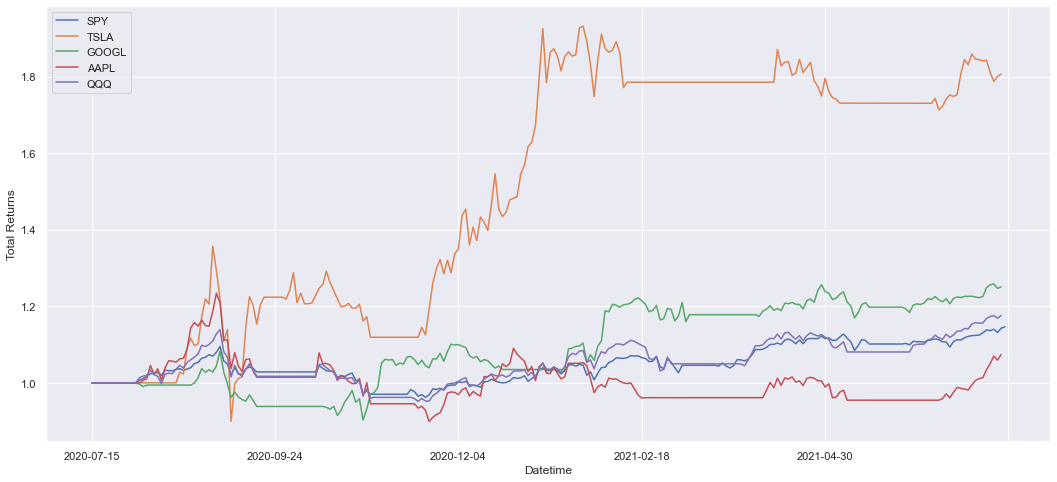

In [83]:
for i in df_all_equity:
    i.plot(figsize = (18,8))
    

plt.grid(True)
plt.xlabel('Datetime')
plt.ylabel('Total Returns')
plt.legend(etf_tickers)
plt.show()
    
